# Data Visualization in Python 
DA Probability & Statistics Learning Series • Python Lesson 2

<img src="https://pyxis.nymag.com/v1/imgs/0c1/267/38d1f78b4d3b94bd1b630ed7f810f3504b-07-softbank-group-05.2x.rhorizontal.w700.jpg" align="center" height="400" width="600"/>

There's always something to learn from our fellow Vision Fund portfolio companies...

*See **#da_prob_stat** for discussion during and after this tutorial.*


## Goals

- Understand the basic tools available to visualize data in Python
- Create wrapper functions around existing visualization functions to make it easier to use them
- Learn to perfrom EDA with data viz in Python
- Give Shreyas a shot at being the TA he never was

## Setup ⚙️

In [39]:
# Import dependencies
from db_utils import get_connection, get_data
import pandas as pd
import datetime

# Data viz
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import figure, axes
from matplotlib.ticker import PercentFormatter
import seaborn as sns

_Note that we are importing a new function called `get_data()` from `db_utils`. This is a wrapper around the the `pd.read_sql()` function you've seen before. Type `get_data()` and hit `Shift+Tab` to see how it works._

**WARM UP:** Complete `get_data()` function

def get_data(input_source, input_type, conn):
    """
    Function to get data from a .sql file or SQL query string input

    Parameters
    ---
    input_source
        Either a string with a valid SQL query or a .sql file

    input_type
        'file' if input is a .sql file; 'text' if input is  a string

    conn
        Connector object returned by get_connection() function
    """

    if input_type == 'text':
        # Use the read_sql method to get the data from Snowflake into a Pandas dataframe
        df = #pd.read(input_source, conn)

    if input_type == 'file':
        # Open the input_source file using the 'with' clause
        with #open(input_source, 'r') as q:

            # Save contents of input_source as a string in query_str
            query_str = #q.read()

            # Use the read_sql method to get the data from Snowflake into a Pandas dataframe
            df = #pd.read_sql(query_str, conn)

    # Make all the columns of the dataframe lowercase
    df.columns = map(str.lower, df.columns)

    return df

### Throwback ⏪

In the homework from the previous Python lesson, we calculated the OTP of Air shipments in March 2020

In [24]:
# Get the database connection and cursor objects
conn, cur = get_connection()

# Get data from the otp.sql file
hw_df = get_data('otp.sql', 'file', conn)

# Rename column headers
hw_df.columns = [
    'shipment_id', 
    'completion_date', 
    'mode_blended', 
    'transit_on_time', 
    'all_transit_milestones_completed'
]

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [25]:
# Create an int version of transit_on_time and convert completion date from string to date
hw_df['transit_on_time'] = hw_df['transit_on_time'].apply(lambda x: x == 'True')
hw_df['transit_on_time_int'] = hw_df['transit_on_time'].apply(lambda x: int(x))

hw_df['completion_dt'] = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in hw_df['completion_date']]
hw_df['completion_month'] = hw_df['completion_dt'].dt.month
hw_df['completion_year'] = hw_df['completion_dt'].dt.year

In [26]:
air_march_otp = \
hw_df[
    (hw_df['all_transit_milestones_completed'] == 'Yes') &
    (hw_df['completion_month'] == 3) &
    (hw_df['completion_year'] == 2020) &
    (hw_df['mode_blended'] == 'Air')
].\
groupby(by=['mode_blended', 'completion_month', 'completion_year']).\
agg({'transit_on_time_int' : 'mean'}).\
reset_index()

air_march_otp.columns = ['mode', 'month', 'year', 'otp_percent']

print(f'Air Shipments OTP - March 2020: {air_march_otp.loc[0,"otp_percent"]*100}%')

Air Shipments OTP - March 2020: 36.0%


## Motivating Question 🤔

> What has OTP looked like for Air shipments over the course of 2020? Have things gotten better since Nate joined the team?

**TODO**: Create dataframe for overtime plot

In [27]:
air_otp = \
hw_df[
    (hw_df['all_transit_milestones_completed'] == 'Yes') &
    (hw_df['mode_blended'] == 'Air')
].\
groupby(by=['mode_blended', 'completion_month', 'completion_year']).\
agg({'transit_on_time_int' : 'mean'}).\
reset_index()

air_otp.columns = ['mode', 'month', 'year', 'otp_percent']

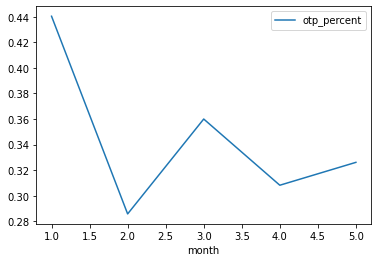

In [28]:
air_otp.plot('month', 'otp_percent')

And there's our first chart! It's not a pretty chart but it's a chart nonetheless... Also, Nate has evidently had a **HUGE** impact on the team in just a few months of being here.

### Open Questions ❓
- How does `.plot()` work?
- Shreyas can you **please** label your axes for me?
- Why does this chart look so 💩?

Let's dive in!

## Tools for Data Visualization 📈

> Great leaders don't blame the tools they are given. They work to sharpen them. - _Simon Sinek_

There are several tools we could use for data viz in Python, including `matplotlib`, `seaborn`, `plotly`, and `bokeh`. They're all quriky in their own ways though, and as analysts, we need to know how to make them work for us.

In this session, we will grapple with the the `matplotlib` package.

_Aside: I personally always get confused between `Module`, `Package`, and `Library`. Here's what the [internet](https://www.quora.com/What-is-the-difference-between-Python-modules-packages-libraries-and-frameworks) says:_
- **Module**: Any `.py` file that contains functions, Classes, global variables, etc. is considered a _module_. We've seen these before a lot: `pandas`, `numpy`, `datetime`, and even the custom created `db_utils` are all _modules_.
- **Package/Library**: In Python, these are synonymous. They are directories of other _packages/libraries_ and _modules_ that consolidate related tools and files in the same place. 
    - We can use the command `import library_name` to get all the _packages_ residing within `library_name`
    - We can also use the command `import library_name.module_name` or `from library_name import module_name` to access a specific _module_ in a _library_

## Matplotlib 📚

`matplotlib` is arguably the most popular and versatile visualization library in Python. It's built off `numpy` and is ideal for 2D plotting. It takes an object oriented approach to visualizing data, similar to how `pandas` uses object oriented methods to create tables.

In `pandas`, we instantiate an object of class `DataFrame` each time we want to create a table from a dictionary ro `csv` file or `sql` query. We then call functions on that object to manipulate and analyze the data.

In `matplotlib`, different classes are used to create different layers of a visualization. It's like drawing on a canvas! However, there are two fundamental ways in which you can use these classes to 'create your picture':
1. You can use an 'object oriented' approach by creating individual objects as you need them; **add to your canvas piece by piece**.
2. You can use convenience wrappers that automatically do some of the object creation *for you*; **start with a shell and go from there**.

We'll walk through both approaches.

### Matplotlib Strucutre 🧱

**Figure:** The base layer that contains one or more charts is called a `Figure`. If you are an artist, the `Figure` is your canvas.
- The `Figure` class lives in the module `matplotlib.figure`

In [91]:
## OBJECT ORIENTED

# Create an object of class figure
object_my_fig = figure.Figure(figsize=(4,4))
object_my_fig

<Figure size 288x288 with 0 Axes>

In [92]:
## PYPLOT WRAPPER

# More standard way of creating a figure using pyplot
fig = plt.figure(figsize=(4,4))

<Figure size 288x288 with 0 Axes>

**Axes:** A figure is nothing without the data we want to visualize - it's blank. Objects of class `Axes` contain the data we want to plot.
- `Axes` can be best thought of as, well, axes
- A figure can have multiple axes arranged in different ways
- Each `Axes` object is a chart that you want to plot
- You can provide an `Axes` object with a title, set the number of axis ticks, add a legend, choose the type of chart, and all that good stuff

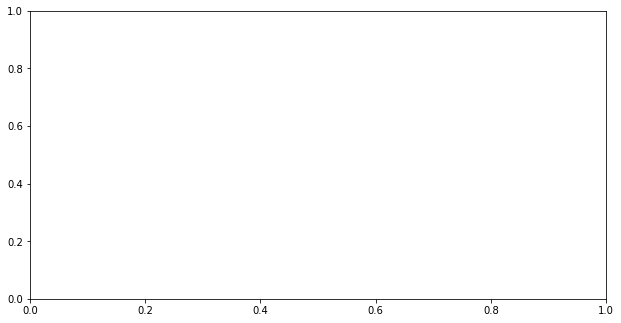

In [146]:
## OBJECT ORIENTED

# Recreating figure because we don't want to add an 
# infinite number of axes to it each time we run this cell
object_my_fig = figure.Figure(figsize=(4,4))

# add_axes() takes a sequence of [left, bottom, width, height] quantities
object_ax = object_my_fig.add_axes([0,0,2,1])

# TODO: Add a set of 1x1 axes starting at the top right of the existing axes
# object_my_fig.add_axes([2,1,1,1])

object_my_fig

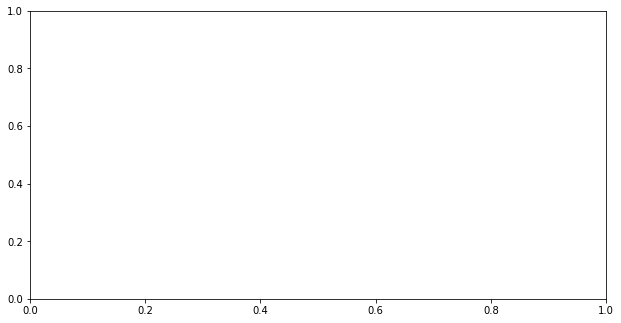

In [103]:
## PYPLOT WRAPPER

# Recreate figure to avoid adding too many axes
fig = plt.figure(figsize=(4,4))

# Add axes to figure using pyplot
ax = plt.axes([0,0,2,1])

**Plot:** Now that you have the skeleton of your chart, you can start adding data to it!
- Charts can come in various forms, but for now, we will just stick with a basic line plot

In [148]:
## OBJECT ORIENTED

# Recreate figure to avoid adding too many axes
object_my_fig = figure.Figure(figsize=(4,4))
object_ax = object_my_fig.add_axes([0,0,2,1])

object_plot = object_ax.plot(air_otp['month'], air_otp['otp_percent'])
# plt.plot(air_otp['month'], air_otp['otp_percent'], ax=object_ax)

# object_ax.legend(labels='otp_percent', loc=0)

object_my_fig

AttributeError: 'FigureCanvasBase' object has no attribute 'manager'
Figure.show works only for figures managed by pyplot, normally created by pyplot.figure().

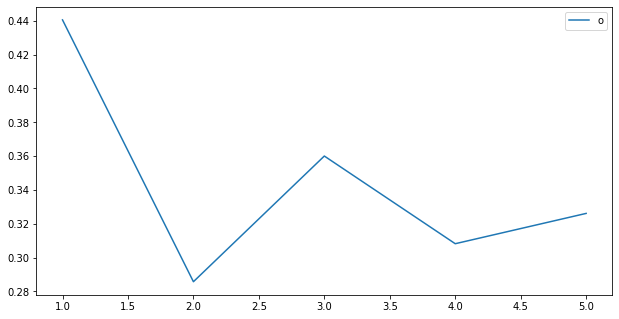

In [139]:
## PYPLOT WRAPPER

# Recreate figure to avoid adding too many axes
fig = plt.figure(figsize=(4,4))
ax = plt.axes([0,0,2,1])

plt.plot(air_otp['month'], air_otp['otp_percent'])

plt.legend(labels='otp_percent', loc=0)

In [116]:
object_plot = object_ax.plot([1,2,3], [1, 2,3])

plt.show()

There are two ways in which you can create visualizations with `matplotlib`:
    - `pyplot` offers convenience wrappers around `matplotlib`s  

`pyplot` is a commonly used module in `matplotlib` that makes MATLAB style plotting available in Python

- `plot()` function in `pyplot` can be called in multiple ways
    - `df.plot()` where `df` is some `pandas` `DataFrame` object
    - `ax.plot()` on any `matplotlib` `Axes` object
    - `plt.plot()` where `plt` refers to the `pyplot` module

There are various convenience wrappers built on top of `matplotlib`s object oriented methods to easily generate plots. Here are a couple:

1. We've already seen the [wrapper accessible via pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html):

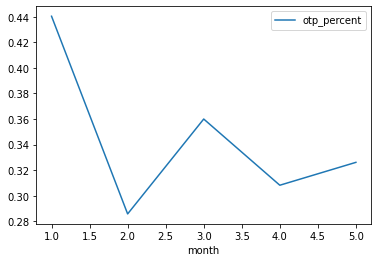

In [29]:
# Chart using df.plot()
air_otp.plot('month', 'otp_percent')

2. Another is using the `matplotlib.pyplot` module that we imported as `plt`

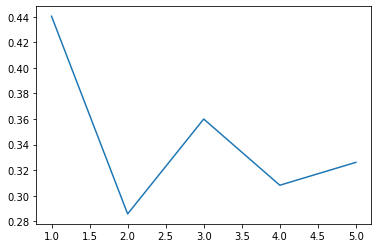

In [30]:
# The chart above was created using the pandas .plot() function
plt.plot(air_otp['month'], air_otp['otp_percent'])

### Standard Process

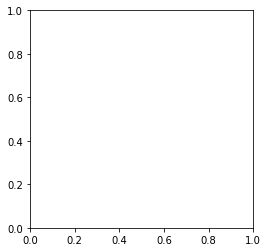

In [67]:
# Initialize 1 figure with one pair of axes together
# this is the same as fig, ax = plt.subplots(1, 1, figsize=(4,4))
fig, ax = plt.subplots(1, 1, figsize=(4,4))

# Scratch

Text(0.5, 1.0, 'Hello')

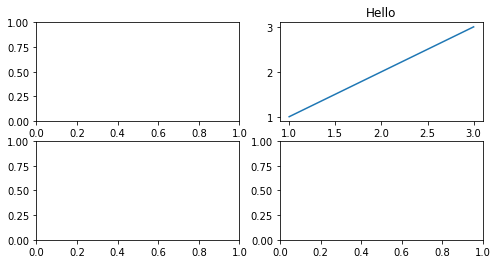

In [20]:
fig, ax = plt.subplots(2,2,figsize=(8,4)) # this is the same as "fig, ax = plt.subplots(1, 1, figsize=(8,4))"

ax[0,1].plot([1,2,3], [1,2,3])
ax[0,1].set_title("Hello")